In [ ]:
import numpy as np
import gym
import time

env = gym.make('CartPole-v0')
observation = env.reset()


num_observation_dimensions = np.size(observation)
num_actions = env.action_space.n

observation_space_high = env.observation_space.high
observation_space_low = env.observation_space.low


# Hyperparameter
num_bins = 10 # Could try different number of bins for the different dimensions
num_states = pow(num_bins,num_observation_dimensions)

def make_observation_bins(min, max, num_bins):
  
    if(min == -np.Inf):
        min = -5 # Should really learn this const instead
    if(max == np.Inf):
        max = 5
        
    bins = np.arange(min, max, (float(max)-float(min))/((num_bins)-2))
    bins = np.sort(np.append(bins, [0])) # Ensure we split at 0
    
    return bins


observation_dimension_bins = []
for observation_dimension in range(num_observation_dimensions):
    #print(observation_dimension)
    min, max = observation_space_low[observation_dimension], observation_space_high[observation_dimension]
    #print(min, max)
    bins = np.linspace(min,max,num_bins)
    #bins = np.sort(np.append(bins, [0]))
    observation_dimension_bins.append(bins)
    
print(observation_dimension_bins)

def observation_to_state(observation):
    state = 0
    for observation_dimension in range(num_observation_dimensions):
        state = state + np.digitize(observation[observation_dimension],observation_dimension_bins[observation_dimension]) \
        * pow(num_bins_per_observation_dimension, observation_dimension)
        
    return state
  
print("Sense Check: Min State: {} Max State: {} Num States: {}".format(observation_to_state([-5,-5,-5,-5.5]), observation_to_state([5,5,5,5.5]),
                                                          num_states))

state_values = np.random.rand(num_states) * 0.1
state_rewards = np.zeros((num_states))
state_transition_probabilities = np.ones((num_states, num_states, num_actions)) / num_states
state_transition_counters = np.zeros((num_states, num_states, num_actions))

def pick_best_action(current_state, state_values, state_transition_probabilities):
    best_action = -1
    best_action_value = -np.Inf
    for a_i in range(num_actions):
        action_value = state_transition_probabilities[current_state,:,a_i].dot(state_values)
        if (action_value > best_action_value):
            best_action_value = action_value
            best_action = a_i
        elif (action_value == best_action_value):
            if np.random.randint(0,2) == 0:
                best_action = a_i
            
    return best_action


def update_state_transition_probabilities_from_counters(probabilities, counters):
    for a_i in range(num_actions):
        for s_i in range(num_states):
            total_transitions_out_of_state = np.sum(counters[s_i,:,a_i])
            if(total_transitions_out_of_state > 0):
                probabilities[s_i,:,a_i] = counters[s_i,:,a_i] / total_transitions_out_of_state
            
    return probabilities


def run_value_iteration(state_values, state_transition_probabilities, state_rewards):
    gamma = 0.995
    convergence_tolerance = 0.01
    iteration = 0
    max_dif = np.Inf
    while max_dif > convergence_tolerance:  
        iteration = iteration + 1
        old_state_values = np.copy(state_values)

        best_action_values = np.zeros((num_states)) - np.Inf
        for a_i in range(num_actions):
            best_action_values = \
                np.maximum(best_action_values, state_transition_probabilities[:,:,a_i].dot(state_values))

        state_values = state_rewards + gamma * best_action_values
        max_dif = np.max(np.abs(state_values - old_state_values))       
    
    return state_values
    
    
                
                
steps = []       
episode_rewards = []
times = []
#env.monitor.start('training_dir3', force=True)
for i_episode in range(50):
    start = time.time()
    current_observation = env.reset()
    current_state = observation_to_state(current_observation)
    
    episode_reward = 0
    
    for t in range(1000):
        action = pick_best_action(current_state, state_values, state_transition_probabilities)
        
        old_state = current_state
        observation, reward, done, info = env.step(action)
        current_state = observation_to_state(observation)
        
        state_transition_counters[old_state, current_state, action] = \
            state_transition_counters[old_state, current_state, action] + 1
        
        episode_reward = episode_reward + reward        
        
        if done:
            episode_rewards.append(episode_reward)
            print("Reward: {}, Average reward over {} trials: {}".format(episode_reward, i_episode, np.mean(episode_rewards[-100:])))          
            
            if(t < 195):
                reward = -1
            else:
                reward = 0
            state_rewards[current_state] = reward

            state_transition_probabilities = update_state_transition_probabilities_from_counters(state_transition_probabilities, state_transition_counters)
            state_values = run_value_iteration(state_values, state_transition_probabilities, state_rewards)
            break
    end = time.time()
    times.append(end-start)

[array([-4.80000019, -3.73333348, -2.66666677, -1.60000006, -0.53333335,
        0.53333335,  1.60000006,  2.66666677,  3.73333348,  4.80000019]), array([-3.40282347e+38, -2.64664047e+38, -1.89045748e+38, -1.13427449e+38,
       -3.78091496e+37,  3.78091496e+37,  1.13427449e+38,  1.89045748e+38,
        2.64664047e+38,  3.40282347e+38]), array([-0.41887903, -0.3257948 , -0.23271057, -0.13962634, -0.04654211,
        0.04654211,  0.13962634,  0.23271057,  0.3257948 ,  0.41887903]), array([-3.40282347e+38, -2.64664047e+38, -1.89045748e+38, -1.13427449e+38,
       -3.78091496e+37,  3.78091496e+37,  1.13427449e+38,  1.89045748e+38,
        2.64664047e+38,  3.40282347e+38])]
Sense Check: Min State: 1750 Max State: 2250 Num States: 10000
Reward: 61.0, Average reward over 0 trials: 61.0
Reward: 28.0, Average reward over 1 trials: 44.5
Reward: 29.0, Average reward over 2 trials: 39.333333333333336
Reward: 39.0, Average reward over 3 trials: 39.25
Reward: 29.0, Average reward over 4 trials: 37.

Text(0, 0.5, 'Rewards')

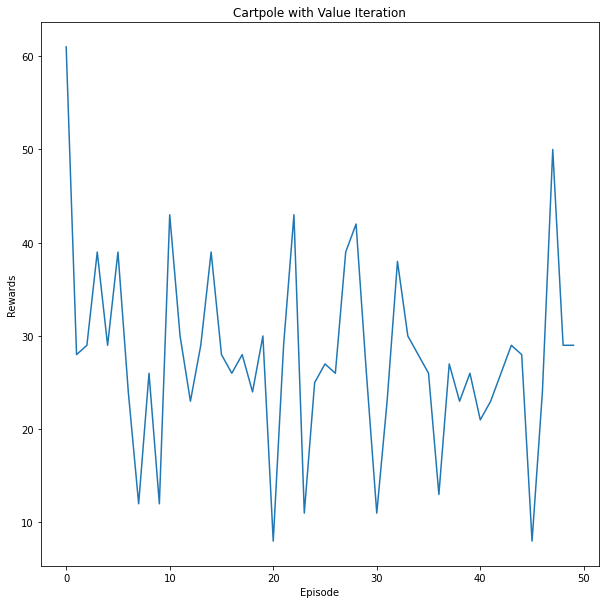

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(episode_rewards)
plt.title("Cartpole with Value Iteration")
plt.xlabel("Episode")
plt.ylabel("Rewards")


Text(0, 0.5, 'Times')

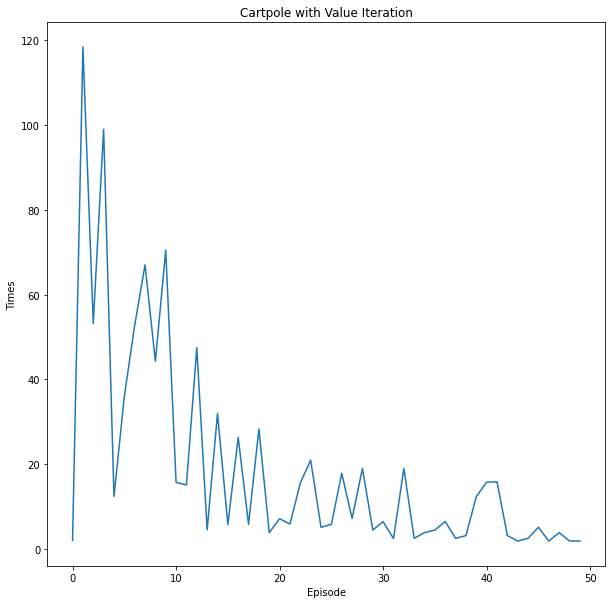

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(times)
plt.title("Cartpole with Value Iteration")
plt.xlabel("Episode")
plt.ylabel("Times")
